In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import random
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt

from pathlib import Path
import os
import re

#need to pip install opencv-python
import cv2
from skimage.color import rgb2gray #convert RGB to gray color

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
import tensorflow.keras as tk
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import sequence
from keras.models import Model
from tensorflow.keras import layers, models


In [4]:
#Get the total classes we have
class_names = [class_name for class_name in os.listdir("./drive/MyDrive/Colab_Notebooks/ImageFolder2") if not class_name.startswith(".")]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)
print(f"We have in total {nb_classes} different classes."+
      f"\nAnd they are:\n {', '.join(classes for classes in class_names)}.")

We have in total 11 different classes.
And they are:
 earbuds, chair, speaker, watches, hat, shorts, shoes, phone, bottle, sunglasses, tshirt.


In [5]:
#Load the data from each folder
def load_image_from_folder(root_dir, max_img_perclass = 4000):

    images = []
    labels = []
    IMAGE_SIZE = (150, 150)

    for folder in os.listdir(root_dir):
        #Because there are some configure file also sitting there  
        if folder.startswith("."):
            continue
        label = class_names_label[folder]
        total_img_perclass = 0
        for root, dirs, files in os.walk(os.path.join(root_dir, folder), topdown = True):
            # Get the path name of the image
            for file in files:
                img_path = os.path.join(root,file)
                #open and resize the image, read in as 3d array
                '''
                The reason we add try except is because some iamges just cannot be read in to cv2
                for example this one: ./updated images/watches/712+lS1mk-L._AC_UL320_.jpg
                I dont know why.

                Also, there are some corrupted images like this one: ./updated images/watches/814cT4PAxeL._AC_UL320_.jpg
                However, cv2 wont allow us to capture this images. We will still keep them in our image pool,
                because they dont really cause any issue.

                If you do want learn more read https://medium.com/joelthchao/programmatically-detect-corrupted-image-8c1b2006c3d3
                and
                https://scikit-image.org/
                '''
                try:
                    image = cv2.imread(img_path)
                    #cv2.cvtColor() method is used to convert an image from one color space to another.
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
                    #is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
                    #The aspect ratio is preserved when we specify the scaling factor.
                    image = cv2.resize(image, IMAGE_SIZE)
                except:
                    continue
                
                total_img_perclass += 1
                if total_img_perclass > max_img_perclass:
                    break
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
    # The original dtypes of image is uint8 (Unsigned integer type, from 0 to 18_446_744_073_709_551_615)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return ((images, labels))

In [6]:
images, labels = load_image_from_folder('./drive/MyDrive/Colab_Notebooks/ImageFolder2',max_img_perclass = 800)
#took 8min to run last time
#Shuffle arrays or sparse matrices in a consistent way.
#This is a convenience alias to resample(*arrays, replace=False) to do random permutations of the collections.
#otherwise imaages are grouped all together based on their classes
images_r, labels_r = shuffle(images, labels, random_state=25)

How many images in each class?


,,,,,,,,,,,
Class,bottle,chair,earbuds,hat,phone,shoes,shorts,speaker,sunglasses,tshirt,watches
Total Amount,800,800,800,800,800,800,800,800,800,800,800


Each image size is: (150, 150).


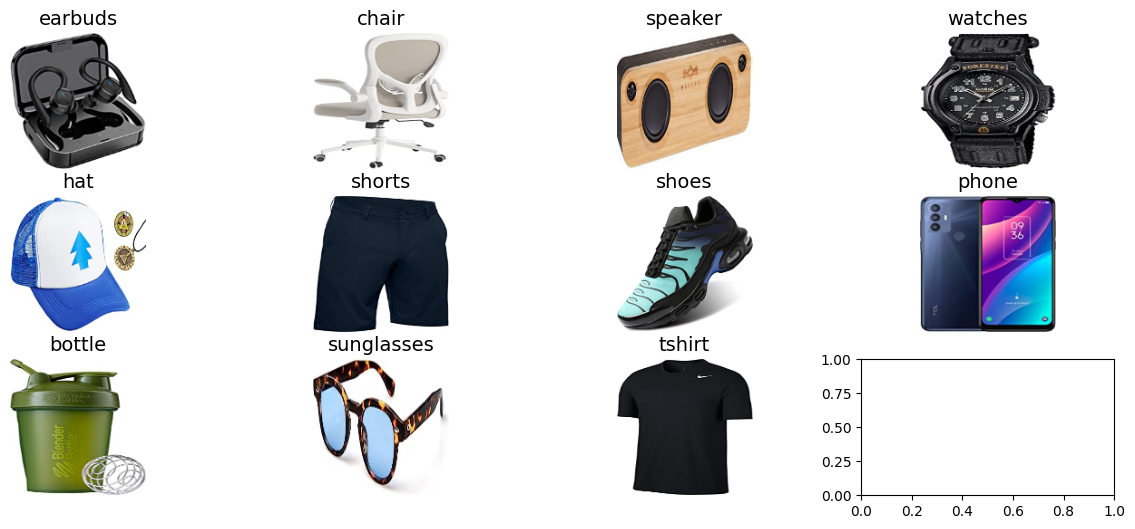

In [7]:
'''
How many images in each class?
'''
print("How many images in each class?")
class_name, count_name = np.array(np.unique(np.array(class_names)[labels_r], return_counts=True))
total_images = pd.DataFrame((class_name, count_name), 
             index = ["Class", "Total Amount"], columns = ['']*len(class_name))
display(total_images)

print(f"Each image size is: {IMAGE_SIZE}.")

#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    x = images_r[labels_r == i][0].astype('uint8')
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

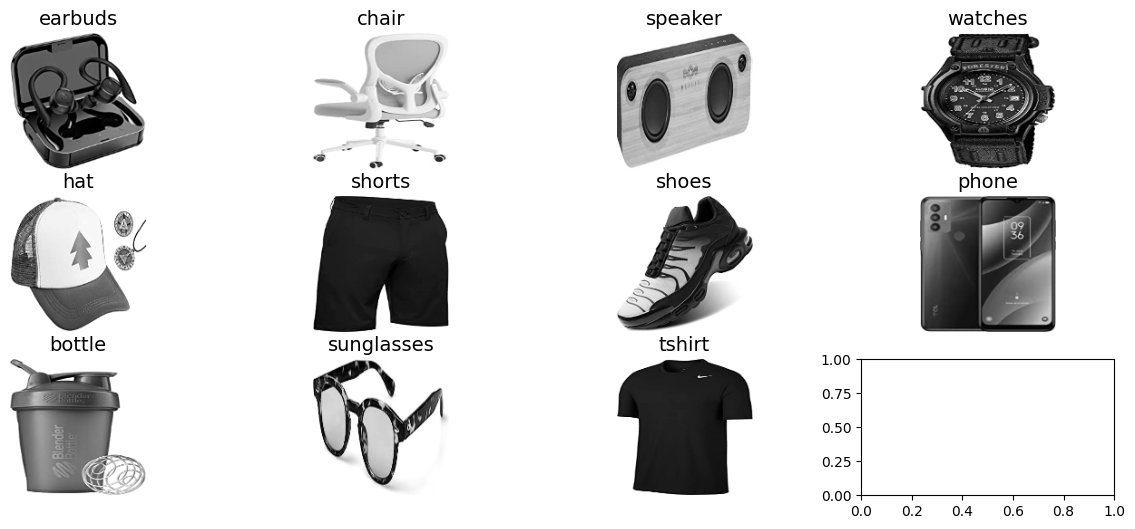

In [8]:
#1: remove colours
images_r_g = np.zeros(images_r.shape[0:3])
for i in range(images_r.shape[0]):
    images_r_g[i] = rgb2gray(images_r[i])
    
#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    #x = images_r[labels_r == i][0].astype('uint8')
    x = images_r_g[labels_r == i][0]
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

#### SVM - took 30 mins to run this

In [10]:
images_r_g_scaled = images_r_g/255.0
X_train, X_test, y_train, y_test = train_test_split(images_r_g_scaled, labels_r, test_size=0.2, random_state=2023)

# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC()
print("The training of the model is started, please wait for while as it may take few minutes to complete")
model=GridSearchCV(svc,param_grid)
model.fit(X_train_scaled,y_train)
print('The Model is trained well with the given images')
model.best_params_
print(model.best_params_)
y_pred=model.predict(X_test_scaled)
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")
print(confusion_matrix(y_test, y_pred))

The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
The model is 67.27272727272727% accurate
[[10  1  2  0  0  0  1  1  2  1  0]
 [ 6 12  2  0  1  0  1  1  2  0  0]
 [ 2  1 19  2  0  0  2  2  0  2  0]
 [ 0  0  2 11  0  0  0  0  0  0  0]
 [ 5  0  4  2 10  0  1  0  0  0  1]
 [ 0  0  1  1  0 16  0  1  0  0  2]
 [ 0  0  0  0  1  0 12  0  0  1  0]
 [ 1  0  2  0  0  1  0 13  0  0  0]
 [ 4  0  1  1  0  1  0  1 10  0  1]
 [ 1  1  0  0  0  0  0  0  0 16  0]
 [ 1  0  0  1  0  0  0  1  0  0 19]]


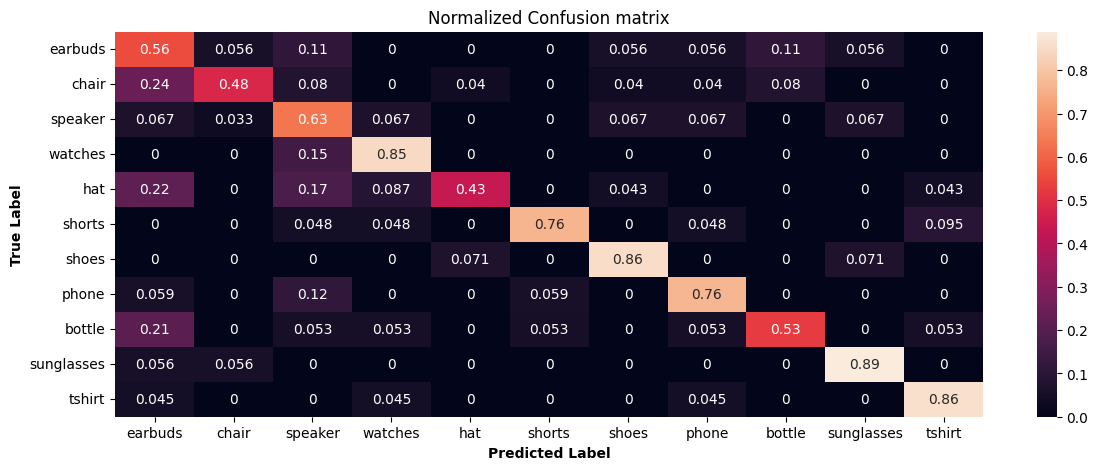

In [11]:
import seaborn as sn

fig, ax = plt.subplots(figsize=(14,5))
CM = confusion_matrix(y_test, y_pred)
row_sums = CM.sum(axis=1)
new_matrix = CM / row_sums[:, np.newaxis]
sn.heatmap(new_matrix, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Normalized Confusion matrix')
ax.set_xlabel("Predicted Label",fontweight ='bold')
ax.set_ylabel("True Label",fontweight ='bold')
plt.show()

Accuracy score for KNearestNeighbour:  0.6573863636363636

#### KNN

In [ ]:
images_r_g_scaled = images_r_g/255.0
nsamples, nx, ny = images_r_g_scaled.shape
images_r_g_scaled = images_r_g_scaled.reshape((nsamples, nx*ny))

X, y = images_r_g_scaled, labels_r
X = StandardScaler().fit(X).transform(X.astype(float))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)


In [16]:
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

knn_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])
params = [{'knn__n_neighbors': [3, 5, 7, 9],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [15, 20]}]
gs_knn = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs_knn.fit(X_train_scaled, y_train)
gs_knn.best_params_
print(gs_knn.best_params_)
# Output:
# {'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
# find best model score
gs_knn.score(X_train_scaled, y_train)

{'knn__leaf_size': 15, 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


1.0

The best model score for knn's parameters - {'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__weights': 'distance'} = 0.9998579545454546

Accuracy score for KNearestNeighbour:  0.5363636363636364
[[ 1  0  3  2  1  2  2  0  2  2  3]
 [ 2  7  1  3  3  2  2  1  1  0  3]
 [ 1  1 18  2  2  2  1  0  1  1  1]
 [ 0  0  2  9  1  0  0  0  0  1  0]
 [ 0  1  5  1 11  2  0  0  2  0  1]
 [ 0  0  2  1  1 16  0  0  1  0  0]
 [ 1  0  0  0  1  0 11  0  1  0  0]
 [ 0  0  2  0  1  1  0 12  1  0  0]
 [ 0  0  3  2  3  4  0  1  5  0  1]
 [ 2  0  0  0  0  2  0  0  2 12  0]
 [ 0  0  1  0  2  2  0  0  0  1 16]]


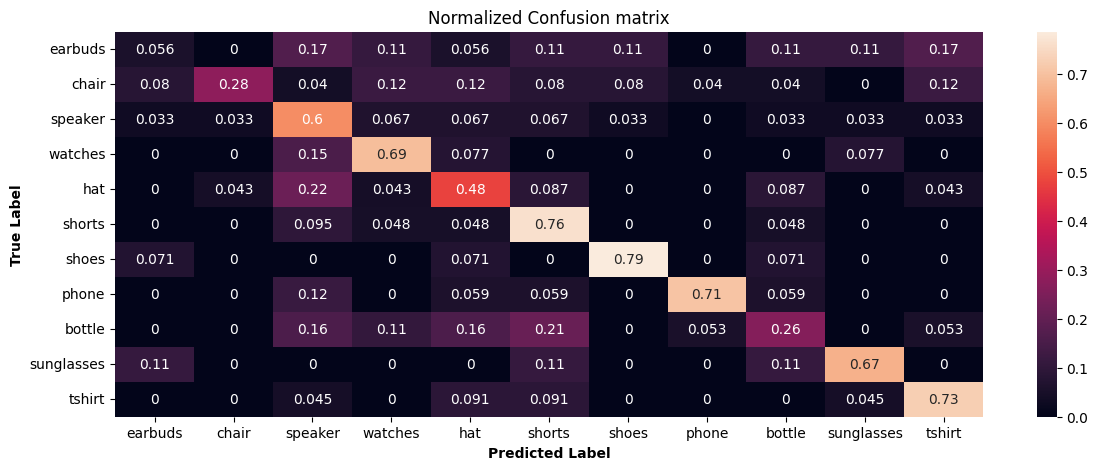

In [17]:
import seaborn as sn

knn=KNeighborsClassifier(n_neighbors=3,weights='distance',leaf_size=15)
knn.fit(X_train_scaled,y_train)
y_pred_knn=knn.predict(X_test_scaled)
acc = accuracy_score(y_pred_knn,y_test)
print("Accuracy score for KNearestNeighbour: ",acc)
print(confusion_matrix(y_test, y_pred_knn))

fig, ax = plt.subplots(figsize=(14,5))
CM = confusion_matrix(y_test, y_pred_knn)
row_sums = CM.sum(axis=1)
new_matrix = CM / row_sums[:, np.newaxis]
sn.heatmap(new_matrix, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Normalized Confusion matrix')
ax.set_xlabel("Predicted Label",fontweight ='bold')
ax.set_ylabel("True Label",fontweight ='bold')
plt.show()

In [ ]:
#prediction of an image using KNN model

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
#Read in one image and show them
test_img1 = cv2.imread("./Images+augmentation/71VCp1uyXYL._AC_UL640_FMwebp_QL65_.webp")
#The original image
print(f"The original image has shape of {test_img1.shape} with datatype of {test_img1.dtype}")
axes[0].imshow(test_img1)
axes[0].set_title("Original Image", fontsize=14)
test_img2 = rgb2gray(test_img1)
axes[1].imshow(test_img2, cmap=plt.cm.gray)
axes[1].set_title("Image after converting BGR to Gray color", fontsize=14)
print(f"The image after converting into gray color has shape of {test_img2.shape} with datatype of {test_img2.dtype}")
test_img3 = cv2.resize(test_img1, (150,150))
axes[2].imshow(test_img3)
axes[2].set_title("Image after resizing", fontsize=14)
print(f"The image after resizing has shape of {test_img3.shape} with datatype of {test_img3.dtype}")
plt.show()
test_img4 = rgb2gray(test_img3)
print('shape of image after color removal',test_img4.shape)

X_test_norm = test_img4/255.0

#reshape
# nx, ny = X_test_norm.shape
# print(nsamples,nx,ny)
X_test_norm = X_test_norm.reshape((1,-1))
print(X_test_norm.shape)
pred_image=knn.predict(X_test_norm)
print(pred_image)

class_names[pred_image[0]]

Gaussian Naive Bayes

In [ ]:
# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for logistic regression
scores = cross_val_score(GaussianNB(), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy")
print("The accuracy rate using Gaussian Naive Bayes is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))

Since the Gaussian Naive Bayes has no hyperparameters to tune so no tuning required.

In [ ]:
# Split the dataset into training (80%) and testing (20%)
images_r_g_scaled = images_r_g/255.0
X_train, X_test, y_train, y_test = train_test_split(images_r_g_scaled, labels_r, test_size=0.2, random_state=2023)

# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

y_pred = gnb.predict(X_test_scaled)

acc_te = accuracy_score(y_test, y_pred)
print("The accuracy from Gaussian Naive Bayes model is: ",acc_te)
print(confusion_matrix(y_test, y_pred))

LDA

In [ ]:
# Crashes my system, do not run it

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
from numpy import mean
from numpy import std

images_r_g_scaled = images_r_g/255.0
X_train, X_test, y_train, y_test = train_test_split(images_r_g_scaled, labels_r, test_size=0.2, random_state=2023)

# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,10):
        steps = [('lda', LinearDiscriminantAnalysis(n_components=i)), ('m', GaussianNB())]
        models[str(i)] = Pipeline(steps=steps)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_scaled, y_train)
    results.append(scores)
    names.append(name)
#  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

In [ ]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

In [ ]:
#tf.keras.layers.Conv2D is expecting 3 dimensions for each image
X_train_norm_cnn= X_train_norm.reshape(-1,150,150,1)
X_test_norm_cnn= X_test_norm.reshape(-1,150,150,1)


# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 1)), 
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation=tf.nn.relu),
#     tf.keras.layers.Dense(11, activation=tf.nn.softmax)
# ])

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape = (150, 150, 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(11,activation=tf.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_norm_cnn, y_train, batch_size=100, epochs=20, validation_split=0.2)
#Returns the loss value & metrics values for the model in test mode.
_,acc = model.evaluate(X_test_norm_cnn, y_test)
print('Test accuracy: %.3f' % acc)
# plot_accuracy_loss(history)

Epoch 1/20
8/8 [==============================] - 5s 150ms/step - loss: 2.5511 - accuracy: 0.1619 - val_loss: 2.3450 - val_accuracy: 0.2102
Epoch 2/20
8/8 [==============================] - 0s 46ms/step - loss: 2.3007 - accuracy: 0.3182 - val_loss: 2.2513 - val_accuracy: 0.3409
Epoch 3/20
8/8 [==============================] - 0s 43ms/step - loss: 2.0386 - accuracy: 0.4389 - val_loss: 2.0931 - val_accuracy: 0.2784
Epoch 4/20
8/8 [==============================] - 0s 43ms/step - loss: 1.6040 - accuracy: 0.4915 - val_loss: 1.6968 - val_accuracy: 0.4375
Epoch 5/20
8/8 [==============================] - 0s 48ms/step - loss: 1.3932 - accuracy: 0.5753 - val_loss: 1.7818 - val_accuracy: 0.4205
Epoch 6/20
8/8 [==============================] - 0s 46ms/step - loss: 1.2126 - accuracy: 0.6392 - val_loss: 1.6317 - val_accuracy: 0.5057
Epoch 7/20
8/8 [==============================] - 0s 42ms/step - loss: 0.9662 - accuracy: 0.7045 - val_loss: 1.5774 - val_accuracy: 0.4943
Epoch 8/20
8/8 [==========

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [ ]:
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(11))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_31 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_32 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 73984)            

In [ ]:
model.compile(optimizer='adam', 
             loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
X_train_norm= X_train_norm.reshape(-1,150,150,1)
X_test_norm= X_test_norm.reshape(-1,150,150,1)

history = model.fit(X_train_norm, y_train, epochs=10, 
                    validation_data=(X_test_norm, y_test))
_,acc = model.evaluate(X_test_norm, y_test)
print('Test accuracy: %.3f' % acc)

Epoch 1/10
28/28 [==============================] - 3s 35ms/step - loss: 0.1911 - accuracy: 0.9534 - val_loss: 2.6509 - val_accuracy: 0.5364
Epoch 2/10
28/28 [==============================] - 1s 23ms/step - loss: 0.0545 - accuracy: 0.9875 - val_loss: 2.5044 - val_accuracy: 0.5955
Epoch 3/10
28/28 [==============================] - 1s 23ms/step - loss: 0.0464 - accuracy: 0.9898 - val_loss: 2.7710 - val_accuracy: 0.5455
Epoch 4/10
28/28 [==============================] - 1s 22ms/step - loss: 0.0513 - accuracy: 0.9852 - val_loss: 2.6214 - val_accuracy: 0.6045
Epoch 5/10
28/28 [==============================] - 1s 22ms/step - loss: 0.0226 - accuracy: 0.9966 - val_loss: 3.4229 - val_accuracy: 0.5864
Epoch 6/10
28/28 [==============================] - 1s 21ms/step - loss: 0.0388 - accuracy: 0.9909 - val_loss: 3.4226 - val_accuracy: 0.5636
Epoch 7/10
28/28 [==============================] - 1s 21ms/step - loss: 0.0967 - accuracy: 0.9682 - val_loss: 2.8639 - val_accuracy: 0.5682
Epoch 8/10
28